# Random Forest Regression 



In [1]:
# Imports
import numpy as np

import zipfile
import io
import csv

import matplotlib.pyplot as plt

# Decision tree implementation

In [2]:
#Using variance since entropy does not work for continuous data
def calculate_variance(y):
    
    return y.size*np.var(y)

In [3]:
def find_split(x, y):
    """Given a dataset and its target values, this finds the optimal combination
    of feature and split point that gives the maximum information gain."""
    
    # Best thus far, initialised to infinity, will be replaced immediately
    best = {'infogain' : np.inf}
    
    total = x.shape[0]
    
    # Loop every possible split of every dimension
    for i in np.random.choice(x.shape[1], x.shape[1], replace=False):
        for split in x[:,i]:
            
            split_left = y[x[:,i] <= split]
            
            
            split_right = y[x[:,i] > split] 
            
            # This might cause an issue but try for now
            if split_right.size == 0:
                continue

            
            # infogain is measured by weighted sum of variances of left and right splits, 
            # i.e. a 'good' split reduces the spread of labels in the left and right branches
            infogain = 1/total*(calculate_variance(split_left) + calculate_variance(split_right))
            
            if infogain < best['infogain']:
                
                left_indices = np.where(x[:,i] <= split)[0]
                
                right_indices = np.where(x[:,i] > split)[0]
                
                best = {'feature' : i,
                        'split' : split,
                        'infogain' : infogain, 
                        'left_indices' : left_indices,
                        'right_indices' : right_indices}
    return best

In [4]:
# Recurively build the tree
def build_tree(x, y, max_depth = np.inf):
    # Check if either of the stopping conditions have been reached, max depth reached or split only contains one value
    if max_depth==1 or (y==y[0]).all():
        # Generate leaf node
        # The value of the leaf node is the value which occurs most
        classes, counts = np.unique(y, return_counts=True)
        return {'leaf' : True, 'class' : classes[np.argmax(counts)]}
    
    else:
        move = find_split(x, y)
        
        left = build_tree(x[move['left_indices'],:], y[move['left_indices']], max_depth - 1)
        right = build_tree(x[move['right_indices'],:], y[move['right_indices']], max_depth - 1)
        
        return {'leaf' : False,
                'feature' : move['feature'],
                'split' : move['split'],
                'infogain' : move['infogain'],
                'left' : left,
                'right' : right}

In [5]:
def predict(tree, samples):
    """Predicts class for every entry of a data matrix."""
    ret = np.empty(samples.shape[0], dtype=float)
    ret.fill(-1)
    indices = np.arange(samples.shape[0])
    
    def tranverse(node, indices):
        nonlocal samples
        nonlocal ret
        
        if node['leaf']:
            ret[indices] = node['class']
        
        else:
            going_left = samples[indices, node['feature']] <= node['split']
            left_indices = indices[going_left]
            right_indices = indices[np.logical_not(going_left)]
            
            if left_indices.shape[0] > 0:
                tranverse(node['left'], left_indices)
                
            if right_indices.shape[0] > 0:
                tranverse(node['right'], right_indices)
    
    tranverse(tree, indices)
    return ret

# Toy problem to test implementation

<IPython.core.display.Javascript object>


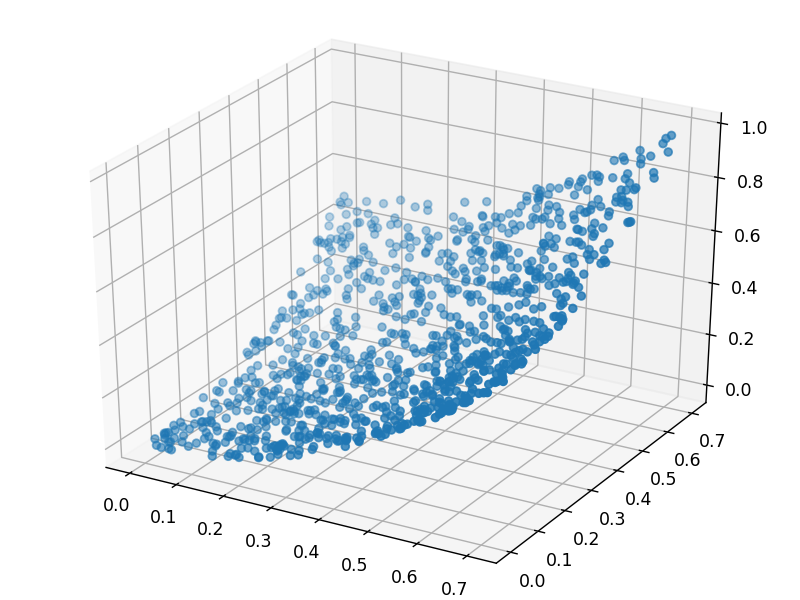

In [6]:
#Toy Problem to test decision tree and regression forest

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

x = np.random.uniform(0,1/np.sqrt(2),1000)
y = np.random.uniform(0,1/np.sqrt(2),1000)

z = x**2 + y**2

sample = (x,y,z)
data = np.stack(sample,1)
np.random.shuffle(data)

train  = data[:800]
test = data[-200:]

#plots sample in 3D space
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(sample[0], sample[1], sample[2])
plt.show()


In [7]:
#Single Tree Evaluation
x_train = train[:,:-1]
y_train = train[:,-1]

x_test = test[:,:-1]
y_test = test[:,-1]

tree = build_tree(x_train, y_train, 10) #build the tree with training set and max_depth 10

#Calculate the accuracy on the training set
pred = predict(tree, x_test)

#Explained Variance Score
from sklearn.metrics import explained_variance_score

print("The explained variance score is:", explained_variance_score(y_test,pred))

#A value close to 1 indicates a model with close to zero error, 
#and a value close to zero indicates a model very close to the baseline.
var_test = np.var(test[:,-1])
diff_pred_actu = pred - y_test
ssd = np.sum(np.square(diff_pred_actu))

R_two = 1-(1/200*ssd/var_test)

print("The R^2 value is:",R_two)
    
#Mean squared percentage error
rel_diff_pred_actu = np.divide((y_test - pred),y_test)

ssd_rel = np.sum(np.square(rel_diff_pred_actu))
MSPE = (100/200)*ssd_rel

print("The mean squared percentage error is:",MSPE)

#Mean Squared Error
MSE = 1/len(diff_pred_actu)*ssd

print("The mean squared error is:",MSE)

The explained variance score is: 0.9914285142020468
The R^2 value is: 0.9913251471969677
The mean squared percentage error is: 2.1709369593682353
The mean squared error is: 0.0003446432838052326


# Random forest implementation

In [8]:
def bootstrap_draws(data_size, num_draws):
    #Return a random sample of size 'num_draws', with replacement, from the set [0:data_size-1] 
    
    return np.random.randint(data_size, size=num_draws)

In [9]:
def bootstrap_features_draws(num_features, subspace_size):
    #Return a random sample of size 'subspace_size', without replacement, from the set [1:num_features]
    
    return np.random.choice(range(0,num_features), size=subspace_size, replace=False)
    

In [10]:
def train_trees(num_trees, bootstrap_size, subspace_size, tree_depth, features, labels):
    
    tree_models = []
    num_examples = features.shape[0]
    feature_dim = features.shape[1]
    
    for tree in range(num_trees):
        #random bootstrap draws
        bootstrap_index = bootstrap_draws(num_examples, bootstrap_size)
        
        #ToDo
        #Add random feature selection
        bootstrap_feat_ind = bootstrap_features_draws(feature_dim, subspace_size)
        
        bootstrap_features = features[bootstrap_index,:]
        bootstrap_features = bootstrap_features[:,bootstrap_feat_ind]
        bootstrap_labels = labels[bootstrap_index]
        
        tree_model = build_tree(bootstrap_features, bootstrap_labels, tree_depth)
        
        tree_models.append(tree_model)
        
    return tree_models

In [11]:
def ensemble_predict(tree_models, samples):
    
    num_models = len(tree_models)
    pred = np.zeros(samples.shape[0])
    #Try using enumerate maybe??
    for _, tree in enumerate(tree_models):
        
        pred += predict(tree, samples)
        
    pred = pred/num_models
    
    return pred

In [14]:
#Random Forest Evaluation
x_train = train[:,:-1]
y_train = train[:,-1]

x_test = test[:,:-1]
y_test = test[:,-1]

#build tree ensemble 
tree_models = train_trees(num_trees=10, bootstrap_size=500, subspace_size=2, tree_depth=10, features=x_train, labels=y_train) 

#Calculate the accuracy on the training set
pred = ensemble_predict(tree_models, x_test)

#Explained Variance Score
from sklearn.metrics import explained_variance_score

print("The explained variance score is:", explained_variance_score(y_test,pred))

#A value close to 1 indicates a model with close to zero error, 
#and a value close to zero indicates a model very close to the baseline.
var_test = np.var(test[:,-1])
diff_pred_actu = pred - y_test
ssd = np.sum(np.square(diff_pred_actu))

R_two = 1-(1/200*ssd/var_test)

print("The R^2 value is:",R_two)
    
#Mean squared percentage error
rel_diff_pred_actu = np.divide((y_test - pred),y_test)

ssd_rel = np.sum(np.square(rel_diff_pred_actu))
MSPE = (100/200)*ssd_rel

print("The mean squared percentage error is:",MSPE,"%")

#Mean squared percentage error
MSE = 1/200*ssd

print("The mean squared error is:",MSE)

The explained variance score is: 0.9962897095729899
The R^2 value is: 0.9947981005781386
The mean squared percentage error is: 1.7989024477238431 %
The mean squared error is: 0.00020666629618755115
